# Implementating Algorithms with Logarithmic Pixel Spacing

In [1]:
import numpy as np
from astropy.io import fits
import glob
import lmfit
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline as USpline

In [2]:
files = glob.glob('../data/*.fits')
fname = files[0]
with fits.open(fname) as f:
    flux = f[1].data['flux']
    lglm = f[1].data['loglam']
    ivar = f[1].data['ivar']
lnlm = 10**lglm

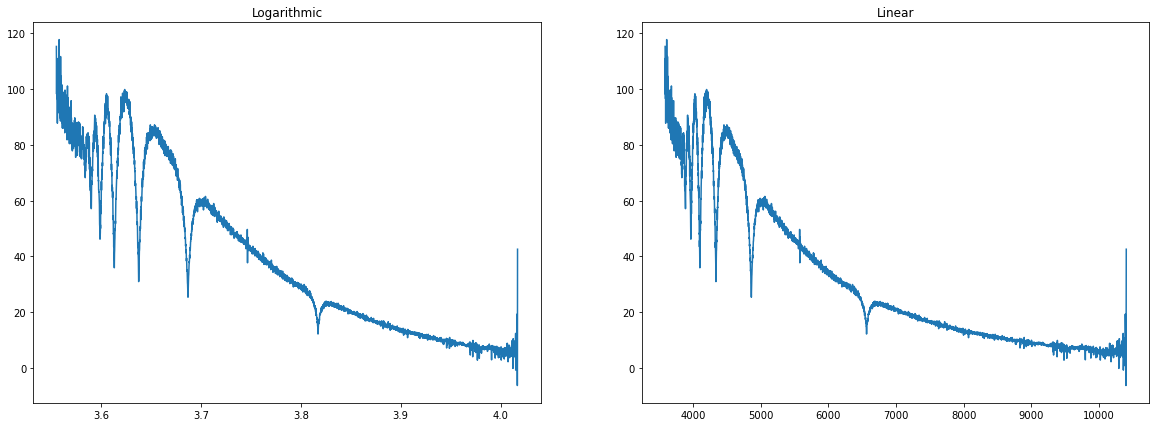

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))

ax[0].plot(lglm, flux)
ax[0].set_title('Logarithmic')

ax[1].plot(lnlm, flux)
ax[1].set_title('Linear')

plt.show()

## Redshift Algorithm

In [4]:
def crop(arr, cdx, window_size):
    '''
    Returns a section of the array centered on cdx, with total width window_size.
    '''
    return arr[cdx-window_size//2:cdx+window_size//2]

def mask_cntr(arr, l, r, frac=True):
    '''
    Masks out the center of the array, leaving the array with indices less than l, or greater than r.
    '''
    if frac:
        ldx = round(len(arr)*l)
        rdx = round(len(arr)*r)
    else:
        ldx = l
        rdx = r
    return np.concatenate((arr[:ldx], arr[rdx:]))

In [5]:
def lin_res(params, x, data, ivar):
    '''
    Returns the weighted residuals of a given linear model and the real data.
    '''
    return (data-lin_model(x, params['m'], params['b']))*np.sqrt(ivar)

def lin_model(x, m, b):
    return m*x + b

In [6]:
def fit_cont(lmbd, flux, ivar):
    '''
    Given a small section of spectrum around an absorption line, fits the local linear continuum and normalization.
    '''
    lmbd_corr = mask_cntr(lmbd, 0.25, 0.75)
    flux_corr = mask_cntr(flux, 0.25, 0.75)
    ivar_corr = mask_cntr(ivar, 0.25, 0.75)
    
    lpar = lmfit.Parameters()
    lpar.add('b', value=flux_corr[0], vary=True)
    lpar.add('m', value=0, vary=True)
    lfit = lmfit.minimize(lin_res, lpar, args=(lmbd_corr, flux_corr, ivar_corr))
    m = lfit.params['m'].value
    b = lfit.params['b'].value
    
    flux_cont = lin_model(lmbd, m, b)
    flux_norm = flux/flux_cont
    
    return flux_cont, flux_norm

def dip_model(abs_line, amplitude, sigma):
    '''
    Returns the dip model and parameters.
    '''
    cnst = lmfit.models.ConstantModel()
    cnst.set_param_hint('c', value=1, vary=False)
    psvt = lmfit.models.PseudoVoigtModel()
    psvt.set_param_hint('center', value=abs_line, vary=True)
    psvt.set_param_hint('amplitude', value=amplitude, vary=True)
    psvt.set_param_hint('sigma', value=sigma, vary=True)
    dpar = psvt.make_params()
    dpar.update(cnst.make_params())
    dmodel = cnst-psvt
    return dmodel, dpar

def fit_dip(lmbd, flux, dmodel, dpar):
    '''
    Completes one iteration of fitting the dip.
    '''
    dfit = dmodel.fit(flux, dpar, x=lmbd)
    dpar = dfit.params
    flux_mdip = dmodel.eval(dpar, x=lmbd)
    mu = dfit.params['center'].value
    return flux_mdip, mu, dpar

In [7]:
def plot_cont(axis, lmbd, flux, ivar, cont, cutoffs):
    axis.set_title('Fitted continuum on data')
    axis.errorbar(lmbd, flux, yerr=1/ivar, fmt='.', label='data')
    axis.plot(lmbd, cont, label='continuum')
    axis.axvline(x=cutoffs[0], color='#DA0', label='linear fit cutoff')
    axis.axvline(x=cutoffs[1], color='#DA0')
    axis.legend()
    return axis

In [8]:
def find_center_line(lmbd, flux, ivar, abs_line, window_cont=300, plot=True):
    '''
    Given a spectrum and an expected absorption line, finds the observed central wavelength of the line.
    '''
    cdx = np.searchsorted(lmbd, (abs_line))
    lmbd_crop = crop(lmbd, cdx, window_cont)
    flux_crop = crop(flux, cdx, window_cont)
    ivar_crop = crop(ivar, cdx, window_cont)

    flux_cont, flux_norm = fit_cont(lmbd_crop, flux_crop, ivar_crop)

    if plot:
        plt.figure(figsize=(10,6))
        axes = plt.axes()
        axes = plot_cont(axes, lmbd_crop, flux_crop, ivar_crop, flux_cont,
                        (lmbd_crop[window_cont//4], lmbd_crop[3*window_cont//4]))
        plt.show()

        plt.figure(figsize=(15,9))
        plt.title('Iterative fits')
        plt.plot(lmbd_crop, flux_norm, 'k.', label='normalized')
        
    dmodel, dpar = dip_model(abs_line, amplitude=0.5, sigma=np.ptp(lmbd_crop)/4)

    window_iter = 100 # initial window width for dip-fitting
    window_step = 15 # iterative reduction in size
    cdx = len(lmbd_crop)//2 # center of array
    mus = []

    while window_iter > 0:
        lmbd_fcrp = crop(lmbd_crop, cdx, window_iter) # fit crop
        flux_fcrp = crop(flux_norm, cdx, window_iter)
        flux_mdip, mu, dpar = fit_dip(lmbd_fcrp, flux_fcrp, dmodel, dpar)

        if plot:
            plt.plot(lmbd_fcrp, flux_mdip, label='fit on '+str(window_iter))
            plt.axvline(x=mu, color='r')
        
        mus.append(mu)
        window_iter -= window_step
    
    if plot:
        plt.axvline(x=abs_line, color='k', label=r'$line_{abs}$')
        plt.legend()
        # plt.xlim((6450,6700))
        plt.show()
    
    return np.mean(mus)

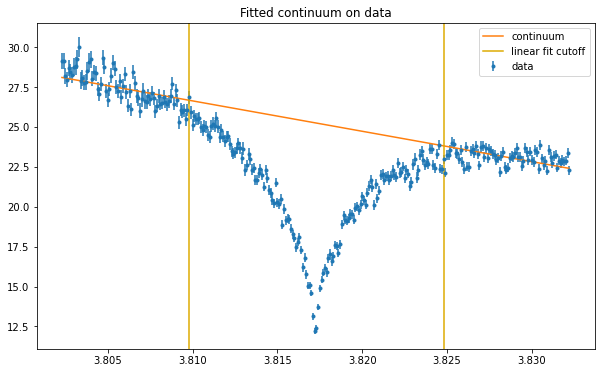

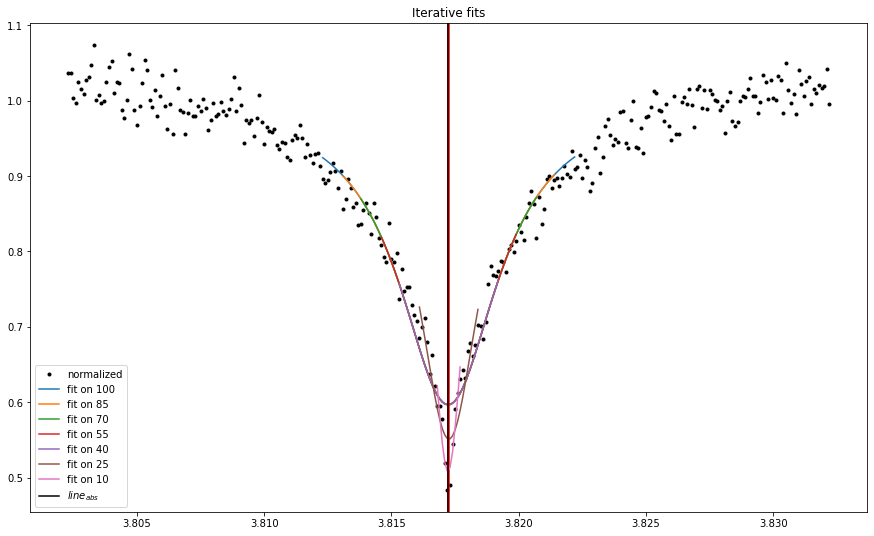

In [9]:
halpha_lg = np.log10(6564.61) # log(Angstroms)
mu_lg = find_center_line(lglm, flux, ivar, halpha_lg)

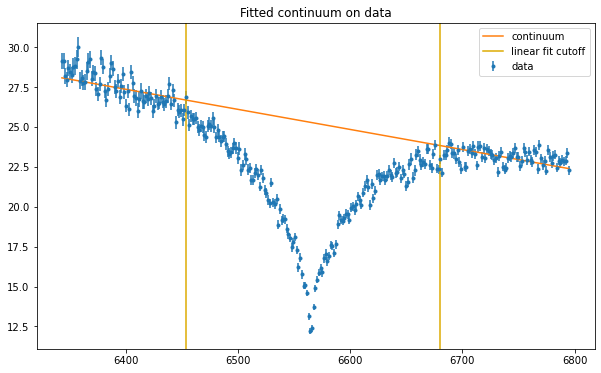

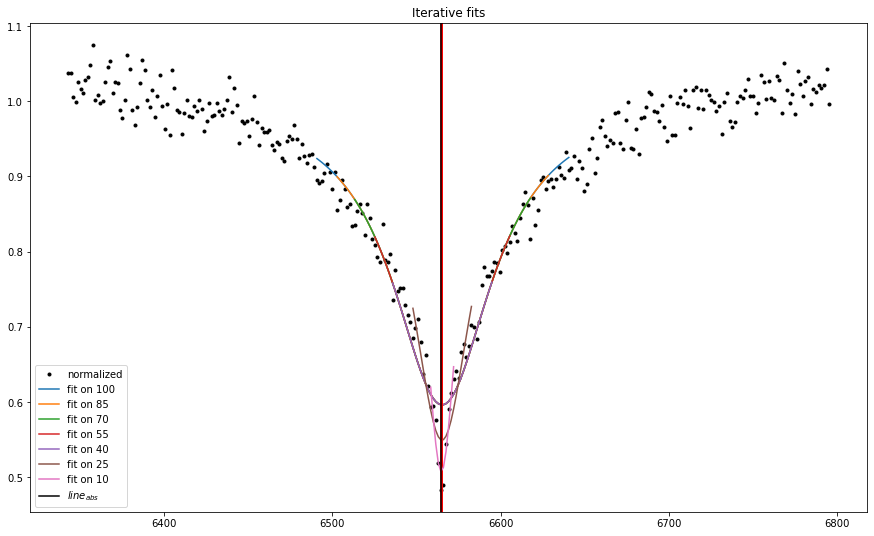

In [10]:
halpha_ln = 6564.61
mu_ln = find_center_line(lnlm, flux, ivar, halpha_ln)

In [11]:
print(10**mu_lg, mu_ln)

6564.953024848264 6565.127422461929


In [12]:
def adjust_redshift(lprp, lobs, lmbd, log=False):
    if log:
        diff = lprp - lobs
        return lmbd + diff
    else:
        diff = lprp / lobs
        return lmbd * diff

In [13]:
lgrs = adjust_redshift(halpha_lg, mu_lg, lglm, log=True)
lnrs = adjust_redshift(halpha_ln, mu_ln, lnlm, log=False)

### Confirming redshift values

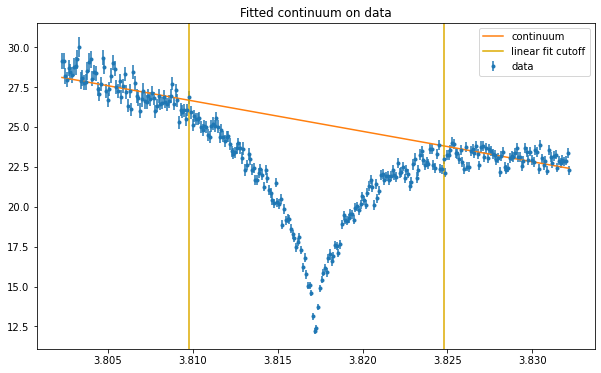

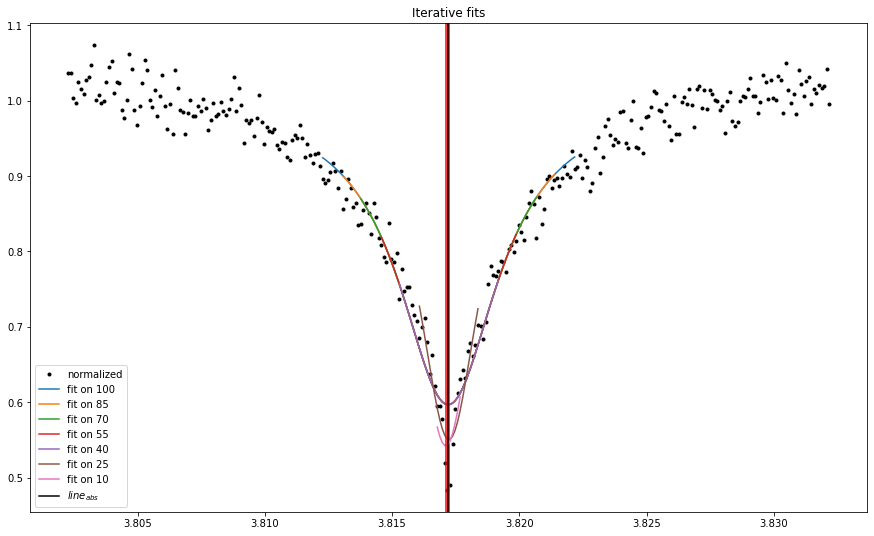

In [15]:
mu_n_lg = find_center_line(lgrs, flux, ivar, halpha_lg)

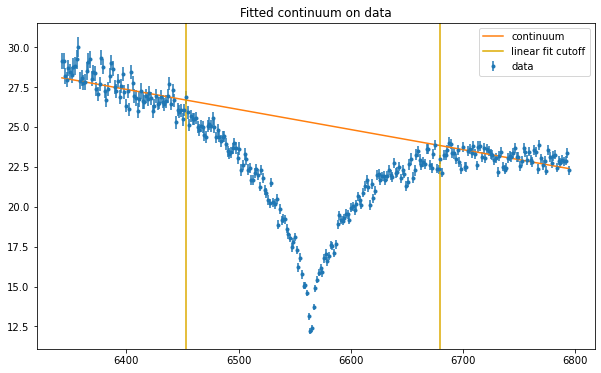

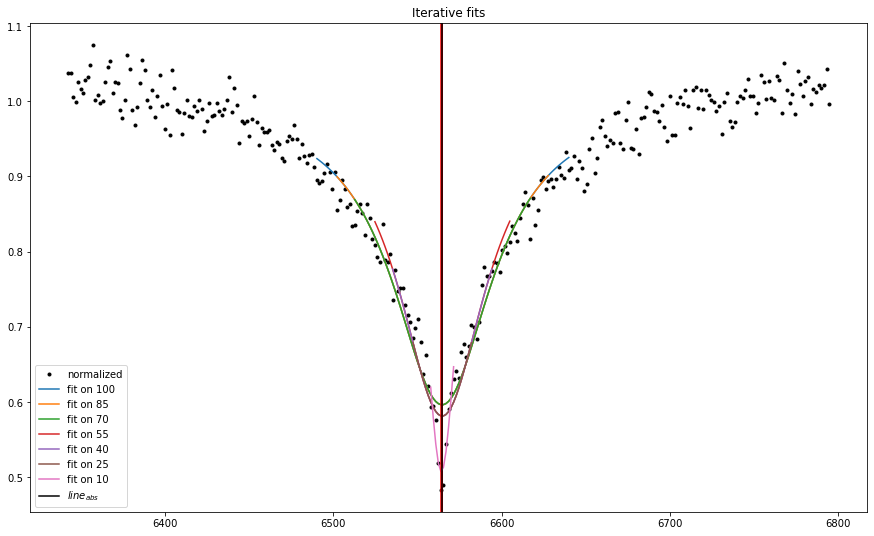

In [16]:
mu_n_ln = find_center_line(lnrs, flux, ivar, halpha_ln)

In [39]:
print('log:', mu_n_lg, halpha_lg)
print('lin:', mu_n_ln, halpha_ln)

log: 3.8171970107352244 3.8172089299869487
lin: 6564.649255453585 6564.61


## Grid Interpolation - Spline

In [29]:
def grid_spl_interp(lmbd, flux, ivar, min, max, step, k=1):
    cnt = (max - min) / step
    grid = np.linspace(min, max, int(cnt))
    spl = USpline(lmbd, flux, w=ivar, k=k)
    fxgd = spl(grid)
    return grid, fxgd

In [35]:
grid_ln, fxgd_ln = grid_spl_interp(lnlm, flux, ivar, 3800, 9200, 1)
grid_lg, fxgd_lg = grid_spl_interp(lglm, flux, ivar, np.log10(3800), np.log10(9200), 1e-4)

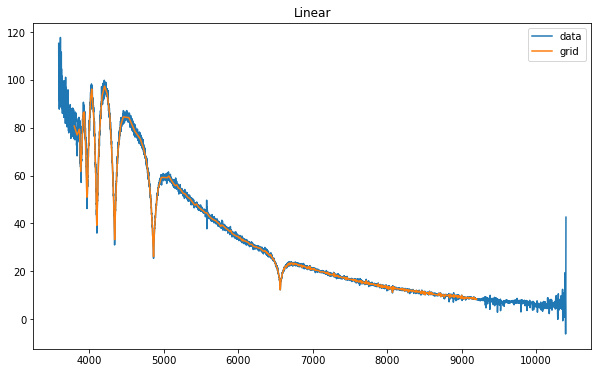

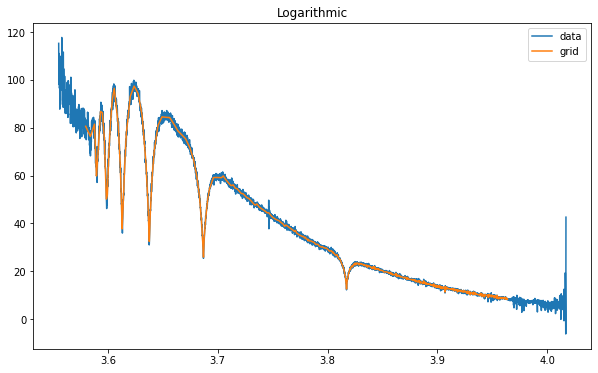

In [37]:
def plot_interp(lmbd, flux, grid, fxgd, name):
    plt.figure(figsize=(10,6))
    plt.title(name)
    plt.plot(lmbd, flux, label='data')
    plt.plot(grid, fxgd, label='grid')
    plt.legend()
    plt.show()

plot_interp(lnlm, flux, grid_ln, fxgd_ln, 'Linear')
plot_interp(lglm, flux, grid_lg, fxgd_lg, 'Logarithmic')

In [38]:
print(grid_lg.shape, grid_ln.shape)

(3840,) (5400,)
